In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 22px;
</style>

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import numpy as np
import torch
from koopman_autoencoder import *

In [38]:
if torch.cuda.is_available():
    device = torch.device('cuda:3')
else:
    device = torch.device('cpu')

## Load dataset

In [39]:
def build_dataset(data_dict):
    time = []
    data = []
    I_p = []
    for index, contents in data_dict.items():
        time.append(contents['time'])
        data.append(contents['data'])
        I_p.append(contents['I_p'])
    
    data = np.array(data)
    x_data = data[:-1,:]
    y_data = data[1:,:]
    dt_data = (time[1] - time[0]) * np.ones((data.shape[0] -1 , 1))
    I_p = np.reshape(np.array(I_p)[:-1], (-1,1))
    u_data = np.concatenate((dt_data, I_p), axis = 1)
    return x_data, y_data, u_data

In [40]:
import numpy as np
import os

x_dataset = []
y_dataset = []
u_dataset = []

for suffix in range(10, 60):
    data_file_path = '../data/data_dict_' + str(suffix) + '.npy'
        
    # Check if the file exists before trying to load it
    if os.path.exists(data_file_path):
        data_dict = np.load(data_file_path, allow_pickle=True).item()
        x_data, y_data, u_data = build_dataset(data_dict)
        x_dataset.append(x_data)
        y_dataset.append(y_data)
        u_dataset.append(u_data)
    else:
        print(f"File not found: {data_file_path}")


File not found: ../data/data_dict_25.npy
File not found: ../data/data_dict_44.npy


In [41]:
x_data = np.concatenate(x_dataset, axis = 0)
y_data = np.concatenate(y_dataset, axis = 0)
u_data = np.concatenate(u_dataset, axis = 0)
x_data.shape

(7221, 6957)

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np


# Scaling the datasets
scaler_x = StandardScaler().fit(x_data)
scaler_u = StandardScaler().fit(u_data)

x_data_scaled = scaler_x.transform(x_data)
y_data_scaled = scaler_x.transform(y_data)
u_data_scaled = scaler_u.transform(u_data)

shuffled_indices = np.arange(len(x_data))
np.random.shuffle(shuffled_indices)

x_data_scaled = x_data_scaled[shuffled_indices]
y_data_scaled = y_data_scaled[shuffled_indices]
u_data_scaled = u_data_scaled[shuffled_indices]

x_train, x_test = train_test_split(x_data_scaled, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(y_data_scaled, test_size=0.2, random_state=42)
u_train, u_test = train_test_split(u_data_scaled, test_size=0.2, random_state=42)


In [43]:
n_input = x_data.shape[1]
layer_sizes_dic = [64, 64, 128]
layer_sizes_k = [64, 64, 64]

n_psi_train = 128
u_dim = 2

model_psi, model_koopman, model_inv_psi, model_predict, model_auto \
= Build_model(n_input, layer_sizes_dic, layer_sizes_k, n_psi_train, u_dim, para = True)

In [44]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
u_train = torch.tensor(u_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
u_test = torch.tensor(u_test, dtype=torch.float32)

# Create a dataset
dataset = TensorDataset(x_train, y_train, u_train)

# Create a data loader
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define the optimizer
optimizer = Adam(list(model_koopman.parameters()) + 
                       list(model_inv_psi.parameters()), lr=0.0001)

mse_loss = nn.MSELoss()

lambda_1 = 1.0
lambda_2 = 1.0
lambda_3 = 1.0


In [45]:
# Initialize a list to store the loss values
train_losses = []
val_losses = []

# Training process

for step in range(200):
    for x_batch, y_batch, u_batch in data_loader:
        # Forward propagation
        optimizer.zero_grad()
        koopman_pred = model_koopman(x_batch, y_batch, u_batch)
        auto_pred = model_auto(x_batch)
        predict_pred = model_predict(x_batch, u_batch)

        loss = lambda_1 * mse_loss(koopman_pred, torch.zeros_like(koopman_pred)) \
               + lambda_2 * mse_loss(auto_pred, x_batch) \
               + lambda_3 * mse_loss(predict_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Training Loss
    koopman_pred = model_koopman(x_train, y_train, u_train)
    auto_pred = model_auto(x_train)
    predict_pred = model_predict(x_train, u_train)

    loss = lambda_1 * mse_loss(koopman_pred, torch.zeros_like(koopman_pred)) \
               + lambda_2 * mse_loss(auto_pred, x_train) \
               + lambda_3 * mse_loss(predict_pred, y_train)        
    train_losses.append(loss.item())
        
    print(f'Epoch: {step}, Loss: {loss.item()}')


    # Test the model
    with torch.no_grad():
        koopman_pred = model_koopman(x_test, y_test, u_test)
        auto_pred = model_auto(x_test)
        predict_pred = model_predict(x_test, u_test)

        loss = lambda_1 * mse_loss(koopman_pred, torch.zeros_like(koopman_pred)) \
           + lambda_2 * mse_loss(auto_pred, x_test) \
           + lambda_3 * mse_loss(predict_pred, y_test)
        val_losses.append(loss.item())

    
    print(f'Epoch: {step}, Loss: {loss.item()}')

Epoch: 0, Loss: 1.4786291122436523
Epoch: 0, Loss: 1.4758265018463135
Epoch: 1, Loss: 0.9480206966400146
Epoch: 1, Loss: 0.9334458112716675
Epoch: 2, Loss: 0.8484436273574829
Epoch: 2, Loss: 0.8299638032913208
Epoch: 3, Loss: 0.6436688899993896
Epoch: 3, Loss: 0.6269252300262451
Epoch: 4, Loss: 0.4126705527305603
Epoch: 4, Loss: 0.4005274176597595
Epoch: 5, Loss: 0.261726438999176
Epoch: 5, Loss: 0.2549295723438263
Epoch: 6, Loss: 0.18171097338199615
Epoch: 6, Loss: 0.179071307182312
Epoch: 7, Loss: 0.13977961242198944
Epoch: 7, Loss: 0.1389440894126892
Epoch: 8, Loss: 0.12108203768730164
Epoch: 8, Loss: 0.1211642324924469
Epoch: 9, Loss: 0.10960177332162857
Epoch: 9, Loss: 0.11036115884780884
Epoch: 10, Loss: 0.10140295326709747
Epoch: 10, Loss: 0.10244028270244598
Epoch: 11, Loss: 0.0960337221622467
Epoch: 11, Loss: 0.09714328497648239
Epoch: 12, Loss: 0.08938392996788025
Epoch: 12, Loss: 0.09075656533241272
Epoch: 13, Loss: 0.07794716209173203
Epoch: 13, Loss: 0.07949446141719818
Ep

Epoch: 109, Loss: 0.0019687667954713106
Epoch: 109, Loss: 0.0019541142974048853
Epoch: 110, Loss: 0.0015090717934072018
Epoch: 110, Loss: 0.0015129095409065485
Epoch: 111, Loss: 0.0017055553616955876
Epoch: 111, Loss: 0.001715921564027667
Epoch: 112, Loss: 0.001674271421507001
Epoch: 112, Loss: 0.0016465735388919711
Epoch: 113, Loss: 0.001858540577813983
Epoch: 113, Loss: 0.0019039380131289363
Epoch: 114, Loss: 0.0014800087083131075
Epoch: 114, Loss: 0.0014625699259340763
Epoch: 115, Loss: 0.0014076163060963154
Epoch: 115, Loss: 0.0014020117232576013
Epoch: 116, Loss: 0.0014340570196509361
Epoch: 116, Loss: 0.001432589953765273
Epoch: 117, Loss: 0.0015716304769739509
Epoch: 117, Loss: 0.001578940311446786
Epoch: 118, Loss: 0.0015758434310555458
Epoch: 118, Loss: 0.0015380366239696741
Epoch: 119, Loss: 0.0016376052517443895
Epoch: 119, Loss: 0.0015730921877548099
Epoch: 120, Loss: 0.0024411692284047604
Epoch: 120, Loss: 0.002470651175826788
Epoch: 121, Loss: 0.0013663331046700478
Epoch:

In [46]:
err_train = scaler_x.inverse_transform(y_train) - scaler_x.inverse_transform(model_predict(x_train, u_train).detach().numpy())
err_train

array([[-5.25091337e-04,  1.12754617e-04, -4.29677412e-06, ...,
         1.17198996e-04, -1.54691103e-06,  8.61784205e-04],
       [-1.54653633e-03, -2.19437386e-04,  4.90416536e-05, ...,
        -1.12381774e-04, -1.05977288e-05,  7.44004419e-04],
       [ 1.48214283e-03,  8.66449046e-05, -1.45622257e-05, ...,
         5.40450709e-06,  9.91294489e-05, -7.26351467e-04],
       ...,
       [-2.47334589e-03, -2.78464675e-04,  1.41223677e-05, ...,
        -2.39710921e-06,  1.18114902e-04,  3.43255705e-04],
       [ 1.25690684e-03,  1.14937375e-04, -1.87947279e-05, ...,
         1.02129450e-04,  1.28207047e-05, -1.89647245e-04],
       [ 2.13895086e-03,  8.29006283e-05, -4.68104652e-06, ...,
         9.69282905e-06,  5.41751289e-05, -8.24095399e-04]])

In [47]:
dt = u_data[:,0:1]
Ip = u_data[:,1:2]

In [120]:
x_train_dmd = scaler_x.inverse_transform(x_train)
u_train_dmd = scaler_u.inverse_transform(u_train)

In [121]:
X = x_train_dmd * u_train_dmd[:,0:1]
print(X.shape)
K, _, _, _ = np.linalg.lstsq(X, err_train, rcond=None)

(5776, 6957)


In [122]:
X

array([[ 9.43000714e-05,  9.88346646e-06, -1.84504443e-06, ...,
         1.03029569e-05,  9.77529615e-06, -6.40651268e-05],
       [-9.53373457e-05, -9.99047628e-06,  1.85885843e-06, ...,
        -8.21818069e-07, -1.19563102e-06,  2.12341397e-05],
       [ 1.17062676e-04,  1.22678156e-05, -2.28504413e-06, ...,
         6.50665233e-06,  6.45192923e-06, -5.01289862e-05],
       ...,
       [ 1.25116479e-05,  1.31056430e-06, -2.42179936e-07, ...,
        -2.67215252e-06, -2.38620245e-06,  1.21531747e-05],
       [ 6.18027968e-05,  6.47642126e-06, -1.20524300e-06, ...,
         1.22995572e-06,  1.40669155e-06, -1.67010183e-05],
       [ 6.02031796e-05,  6.30844451e-06, -1.17290895e-06, ...,
        -2.05784302e-06, -1.59499325e-06, -5.42402451e-07]])

In [123]:
u_train_dmd[:,0:1]

array([[0.00095238],
       [0.00071429],
       [0.00047619],
       ...,
       [0.00051282],
       [0.00042553],
       [0.00066667]])

In [124]:
x_train_dmd

array([[ 0.09901507,  0.01037764, -0.0019373 , ...,  0.0108181 ,
         0.01026406, -0.06726838],
       [-0.13347228, -0.01398667,  0.0026024 , ..., -0.00115055,
        -0.00167388,  0.0297278 ],
       [ 0.24583162,  0.02576241, -0.00479859, ...,  0.01366397,
         0.01354905, -0.10527087],
       ...,
       [ 0.02439771,  0.0025556 , -0.00047225, ..., -0.0052107 ,
        -0.00465309,  0.02369869],
       [ 0.14523657,  0.01521959, -0.00283232, ...,  0.0028904 ,
         0.00330573, -0.03924739],
       [ 0.09030477,  0.00946267, -0.00175936, ..., -0.00308676,
        -0.00239249, -0.0008136 ]])

In [125]:
U, S, VT = np.linalg.svd(K)

In [126]:
S[0]

180013229934.31927

In [131]:
np.max(abs(err_train))

0.722054427590438

In [133]:
np.max(abs(err_train - X @ K))

0.7915930244155066

In [119]:
err_train_auto = y_train - X @ K
err_train_auto

tensor([[ 0.8747,  0.8742, -0.8753,  ...,  1.1817,  1.1713, -1.1109],
        [-0.7820, -0.7833,  0.7825,  ..., -0.0512, -0.1070,  0.3588],
        [ 1.2859,  1.2872, -1.2868,  ...,  0.9302,  0.9698, -1.1305],
        ...,
        [-0.0958, -0.0981,  0.0997,  ..., -0.7129, -0.6798,  0.5633],
        [ 0.7493,  0.7503, -0.7494,  ...,  0.0794,  0.1303, -0.3471],
        [ 0.4595,  0.4615, -0.4605,  ..., -0.3737, -0.3185,  0.0913]],
       dtype=torch.float64)

In [60]:
err_train_auto_scaled = scaler_x.transform(err_train_auto)
err_train_auto_scaled = torch.tensor(err_train_auto_scaled, dtype=torch.float32)

In [61]:
# Initialize a list to store the loss values
train_losses_2 = []

# Create a dataset
dataset_2 = TensorDataset(x_train, err_train_auto_scaled, u_train)

# Create a data loader
data_loader_2 = DataLoader(dataset_2, batch_size=64, shuffle=True)


for step in range(50):
    for x_batch, y_batch, u_batch in data_loader_2:
        # Forward propagation
        optimizer.zero_grad()
        koopman_pred = model_koopman(x_batch, y_batch, u_batch)
        auto_pred = model_auto(x_batch)
        predict_pred = model_predict(x_batch, u_batch)

        loss = lambda_1 * mse_loss(koopman_pred, torch.zeros_like(koopman_pred)) \
               + lambda_2 * mse_loss(auto_pred, x_batch) \
               + lambda_3 * mse_loss(predict_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Training Loss
    koopman_pred = model_koopman(x_train, y_train, u_train)
    auto_pred = model_auto(x_train)
    predict_pred = model_predict(x_train, u_train)

    loss = lambda_1 * mse_loss(koopman_pred, torch.zeros_like(koopman_pred)) \
               + lambda_2 * mse_loss(auto_pred, x_train) \
               + lambda_3 * mse_loss(predict_pred, y_train)        
    train_losses_2.append(loss.item())
        
    print(f'Epoch: {step}, Loss: {loss.item()}')

Epoch: 0, Loss: 0.0007662585121579468
Epoch: 1, Loss: 0.0009619524935260415
Epoch: 2, Loss: 0.0005072714993730187
Epoch: 3, Loss: 0.0006785170990042388
Epoch: 4, Loss: 0.0006079294835217297
Epoch: 5, Loss: 0.001734613673761487
Epoch: 6, Loss: 0.0008001821697689593
Epoch: 7, Loss: 0.0005177005077712238
Epoch: 8, Loss: 0.0006662321975454688
Epoch: 9, Loss: 0.0007714172825217247
Epoch: 10, Loss: 0.0008572235237807035
Epoch: 11, Loss: 0.0005725270602852106
Epoch: 12, Loss: 0.0008400137303397059
Epoch: 13, Loss: 0.0005017252988182008
Epoch: 14, Loss: 0.0004899939522147179
Epoch: 15, Loss: 0.000561643682885915
Epoch: 16, Loss: 0.0004966658307239413
Epoch: 17, Loss: 0.0008508880855515599
Epoch: 18, Loss: 0.0005856454954482615
Epoch: 19, Loss: 0.0005206238129176199
Epoch: 20, Loss: 0.0006219935603439808
Epoch: 21, Loss: 0.0004739192081615329
Epoch: 22, Loss: 0.0005078496178612113
Epoch: 23, Loss: 0.0008493043715134263
Epoch: 24, Loss: 0.0008520848350599408
Epoch: 25, Loss: 0.000477884372230619

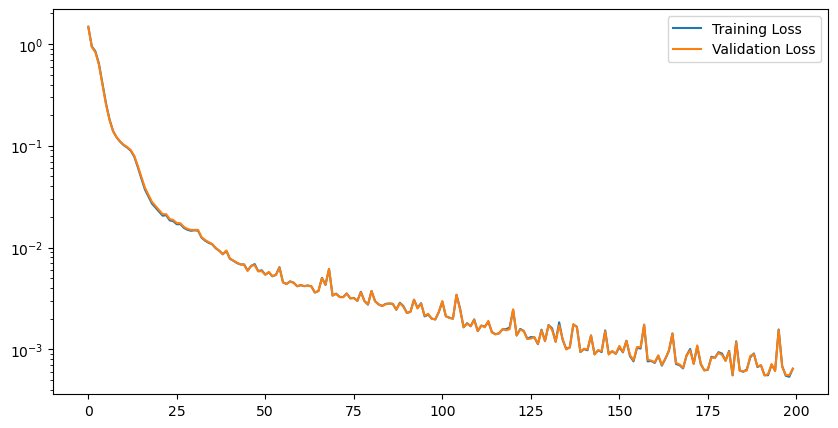

In [62]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.yscale('log')
plt.show()

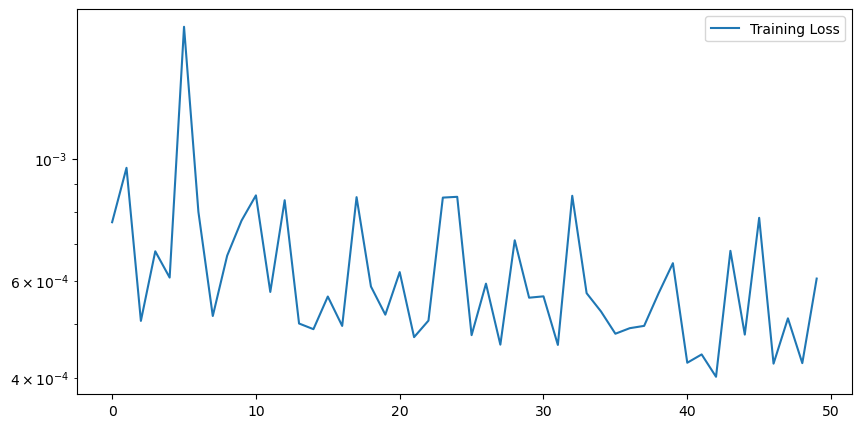

In [63]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_losses_2, label='Training Loss')
plt.legend()
plt.yscale('log')
plt.show()

In [64]:
x_dataset_scaled = [scaler_x.transform(x) for x in x_dataset]
u_dataset_scaled = [scaler_u.transform(u) for u in u_dataset]

In [65]:
para_k = model_koopman.Para_k

In [115]:
import torch

def hybrid_predict(x0, u_data, steps, model_predict, K, scaler_x, scaler_u):
    data_traj = []
    x0 = x0.reshape((1,-1))

    u_scaled_np = scaler_u.transform(u_data)
    u_scaled = torch.from_numpy(u_scaled_np).float()
        
    data_traj.append(x0)
    
    for step in range(steps):
        x0_scaled_np = scaler_x.transform(x0)
        x0_scaled = torch.from_numpy(x0_scaled_np).float()

        u_cur_scaled = u_scaled[step:step+1,:]
        u_cur = u_data[step:step+1,:]
        
        with torch.no_grad():
            y1_scaled = model_predict(x0_scaled, u_cur_scaled)
        y1_scaled_np = y1_scaled.numpy()
        y1_np = scaler_x.inverse_transform(y1_scaled_np)
        
#         print(y1_np)
        
        print(u_cur)
        y2 = x0 @ K * u_cur[0, 0] 
        print(x0 * u_cur[0,0])
        
#         print(y2)
        y = y1_np + y2
        
        data_traj.append(y)
        x0 = y
        
    return data_traj, x0


In [116]:
steps = 2

In [117]:
import numpy as np
import torch

pred_data_traj = []
i = 0
for x, u in zip(x_dataset, u_dataset):
    print(i)
    i = i+1
    x_pred_traj, x0 = hybrid_predict(x[0, :], u, steps, model_predict, K, scaler_x, scaler_u)
    x_pred_traj = np.concatenate(x_pred_traj, axis=0)
    pred_data_traj.append(x_pred_traj)
    break

0
[[0.002 0.   ]]
[[0. 0. 0. ... 0. 0. 0.]]
[[2.00000000e-03 3.75999701e+01]]
[[-1.03390932e-04 -1.06701897e-05  2.04795320e-06 ... -6.79401355e-06
  -6.47026394e-06  4.56410050e-05]]


In [78]:
errors = [pred_data_traj[i] - x_dataset[i][:51, :] for i in range(len(pred_data_traj))]

# Calculate the norm of the error for each element
error_norms = [np.linalg.norm(errors[i], axis=1) for i in range(len(errors))]

# Calculate the norm of the original data for each element
data_norms = [np.linalg.norm(x_dataset[i]) for i in range(len(x_dataset))]


# Calculate the ratio of the error norm to the data norm for each element
relative_errors = [error_norms[i] / data_norms[i] for i in range(len(errors))]

# Calculate the mean and standard deviation of the relative errors for each element
mean_relative_errors = np.mean(relative_errors, axis=0)
std_relative_errors = np.std(relative_errors, axis=0)

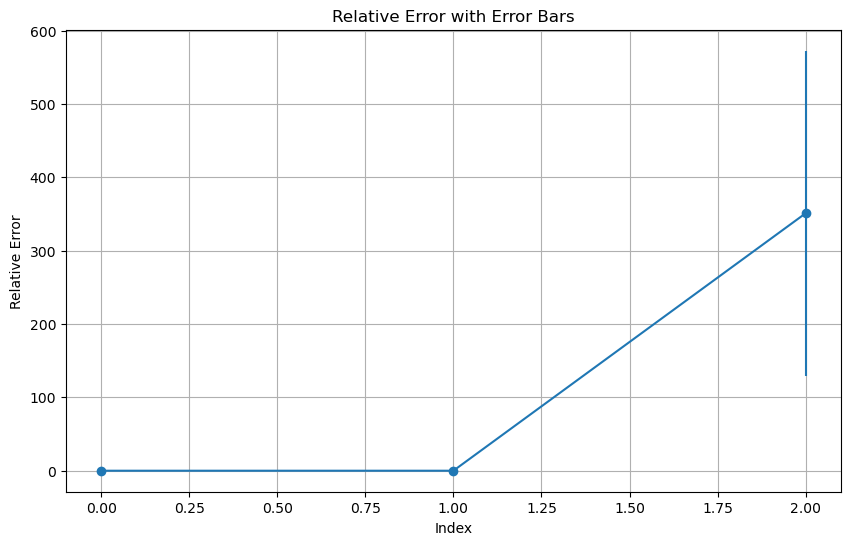

In [89]:
# Plot the relative error with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(range(3), mean_relative_errors[:3], yerr=std_relative_errors[:3], fmt='-o')
plt.xlabel('Index')
plt.ylabel('Relative Error')
plt.title('Relative Error with Error Bars')
plt.grid(True)
plt.show()

In [80]:
domain_error_norms = [np.linalg.norm(errors[i]) for i in range(len(x_dataset))]
domain_relative_error = [domain_error_norms[i]/data_norms[i] for i in range(len(domain_error_norms))]

In [81]:
np.mean(domain_relative_error)

nan

In [82]:
np.std(domain_relative_error)

nan